<a href="https://colab.research.google.com/github/rishubhkhurana/EVA2/blob/master/S2/QuadsAndBirds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Quads Vs Birds
Image Classification using Mobile Net V2.

### Importing Libs

In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import torch
from torchvision.utils import save_image,make_grid
from torchvision.datasets import ImageFolder, DatasetFolder
from PIL import Image
import cv2
import torchvision.transforms as transforms
import numpy as np
from collections import Counter
from fastprogress import progress_bar
from torch.utils.data import random_split,DataLoader
from albumentations import PadIfNeeded,Resize,Compose
import matplotlib.pyplot as plt
import time
import shutil,os
from functools import partial
from torchsummary import summary
import torch.nn as nn
import gc
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:

import sys

In [4]:
sys.path.append('/content/drive/My Drive/Vision')
sys.path.append('/content/drive/My Drive/')

In [5]:

from Vision import *

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!cp -R /content/drive/My\ Drive/OutputData.zip .

In [8]:
!unzip OutputData.zip

Streaming output truncated to the last 5000 lines.
  inflating: OutputData/train/Winged Drones/Image_643.jpg  
  inflating: OutputData/train/Winged Drones/c47722de1299fd8491c18bd9540a5f53.jpg  
  inflating: OutputData/train/Winged Drones/BNXJP2ESCJHSBGVCMBAHRZHCJE.jpg  
  inflating: OutputData/train/Winged Drones/fixed-wing-aircraft-unmanned-aerial-vehicle-helicopter-airplane-drones.jpg  
  inflating: OutputData/train/Winged Drones/Image_694.jpg  
  inflating: OutputData/train/Winged Drones/images (97).jpg  
  inflating: OutputData/train/Winged Drones/image357.jpg  
  inflating: OutputData/train/Winged Drones/image425.jpg  
  inflating: OutputData/train/Winged Drones/image343.jpg  
  inflating: OutputData/train/Winged Drones/delair-UAV-W.jpg  
  inflating: OutputData/train/Winged Drones/th108.jpg  
  inflating: OutputData/train/Winged Drones/Image_680.jpg  
  inflating: OutputData/train/Winged Drones/avy_winged_drone_01.jpg  
  inflating: OutputData/train/Winged Drones/Image_870.jpg  


In [ ]:
!cp /content/drive/My\ Drive/Session2.zip .


In [ ]:
!unzip Session2.zip

In [60]:
! ls Session2/

'Flying Birds'	'Large Quadcopters'  'Small Quapcopters'  'Winged Drones'


In [7]:
!ls -a /content/drive/.shortcut-targets-by-id/

In [ ]:
!cp -R /content/drive/.shortcut-targets-by-id/110/Session2Dataset_final .

In [ ]:
!cp /content/drive/My\ Drive/s2_dataset_cleaned.zip ./

In [ ]:
!unzip s2_dataset_cleaned.zip

In [ ]:
!rm -rf __MACOSX/

In [ ]:
!rm -rf train/.DS_Store

In [10]:
!cp -R /content/drive/My\ Drive/Session2Dataset_final/ .

cp: cannot access '/content/drive/My Drive/Session2Dataset_final/': Input/output error


### Reading Dataset


In [9]:
#datapath = '/content/Session2'
traindatapath = '/content/OutputData/train'
validdatapath = '/content/OutputData/val'

In [11]:
#tfms = transforms.Compose([transforms.ToTensor()])
ds1 = ImageFolder(root=traindatapath)#,transform=tfms) 


In [12]:
ds1.classes

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']

In [14]:
all_files = []
extensions=[]
for r,_,filenames in os.walk(traindatapath):
    extensions.extend([f.split('.')[-1] for f in filenames])

In [15]:

Counter(extensions)

Counter({'jpg': 12089})

In [16]:
ds1 = DatasetFolder(root=traindatapath,loader = lambda x: Image.open(x),extensions=('jpg','jpeg'))

In [17]:
len(ds1)

12089

In [18]:
np.bincount(ds1.targets)

array([6059,  708, 2258, 3064])

### Dataset Transform

In [10]:
def resize(img,size=(224,224),default_scaling=False):
    """
    Resize the image to the given size.
    """
    # width and height of image
    w,h = img.size
    # get the maximum of the sides
    w_new,h_new = size
    if w<h:
        w_new = int(w*size[0]/h)
    else:
        h_new = int(h*size[0]/w)
    if isinstance(img,Image.Image):
        img = np.asarray(img)
    if img.shape[-1]==1 or len(img.shape)==2:
        img = np.stack([img,img,img],axis=-1)
    if img.shape[-1]==4:
        img = img[:,:,:-1]
    if not default_scaling:
        img = Compose([Resize(h_new,w_new),PadIfNeeded(min_height=size[0],min_width=size[1])])(image=img)['image']
    else:
        img = Compose([Resize(size[0],size[1]),PadIfNeeded(min_height=size[0],min_width=size[1])])(image=img)['image']
    return img

In [11]:

tfms = transforms.Compose([transforms.Lambda(partial(resize,default_scaling=False)),transforms.ToPILImage(),transforms.ToTensor()])

### Data Loader

In [12]:
tds = DatasetFolder(root=traindatapath,loader = lambda x: Image.open(x),extensions=('jpg'),transform=tfms)

In [14]:
tds.classes

['Flying Birds', 'Large QuadCopters', 'Small QuadCopters', 'Winged Drones']

In [15]:
for i in progress_bar(range(len(tds)),total=len(tds)):
    img = tds[i]
    try:
        if img[0].shape[0]==1 or img[0].shape[0]==4:
            print(i)
            break
    except UnidentifiedImageError as e:
        print(repr(e))
        continue


In [13]:
dl = DataLoader(tds,batch_size=128,shuffle=True,num_workers=4)

In [14]:
def show_batch(dl,nrow=4,num_images=16):
    batch = next(iter(dl))
    img = np.transpose(make_grid(batch[0].cpu()[:num_images],nrow=nrow).numpy(),(1,2,0))
    plt.figure(figsize=(16,8))
    plt.imshow(img)



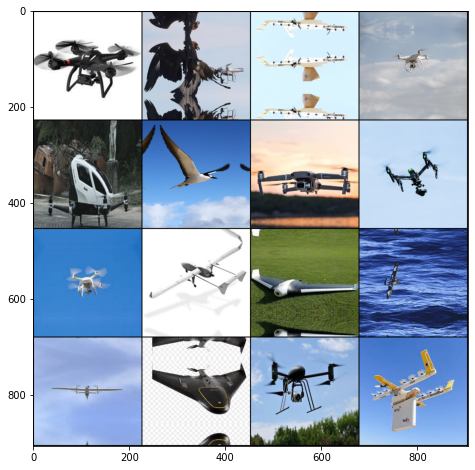

In [15]:
show_batch(dl)

In [25]:
import time
dl_iter = iter(dl)
start = time.time()
next(dl_iter)
print(time.time()-start)


1.7394044399261475


### Data Normalization

In [14]:
len(dl)

95

In [15]:
means = []
sqs = []
count=[]
for i,(x,_) in progress_bar(enumerate(dl),total=len(dl)):
    count.append(x.shape[0])
    means.append(x.mean((0,2,3)).numpy())
    sqs.append((x**2).mean((0,2,3)).numpy())

In [16]:

all_means=(np.stack(means)*np.array(count).reshape(-1,1)).sum(0)/sum(count)

In [17]:
all_sqs=(np.stack(sqs)*np.array(count).reshape(-1,1)).sum(0)/sum(count)

In [18]:
all_stds = np.sqrt(all_sqs-all_means**2)

In [19]:

all_stds,all_means

(array([0.2727084 , 0.25056547, 0.29497393]),
 array([0.52749573, 0.58017221, 0.61191823]))

### Applying Normalization + Data Splitting + data loader

In [20]:
tfms = transforms.Compose([transforms.Lambda(partial(resize,default_scaling=False)),transforms.ToPILImage(),transforms.ToTensor(),
                           transforms.Normalize(mean=all_means,std=all_stds)])

In [19]:
#ds = DatasetFolder(root=datapath,loader = lambda x: Image.open(x),extensions=('jpg'),transform=tfms)
#N = len(ds)
#valid_size = int(0.3*N) 
#train_size = N-valid_size
#train_ds,valid_ds = random_split(ds,[train_size,valid_size])

In [21]:
train_ds = DatasetFolder(root=traindatapath,loader = lambda x: Image.open(x),extensions=('jpg'),transform=tfms)
valid_ds = DatasetFolder(root=validdatapath,loader = lambda x: Image.open(x),extensions=('jpg'),transform=tfms)


In [28]:
len(train_ds),len(valid_ds)

(12089, 3025)

In [33]:
np.bincount(train_ds.targets)/len(train_ds)

array([0.50119944, 0.05856564, 0.18678137, 0.25345355])

In [34]:
np.bincount(valid_ds.targets)/len(valid_ds)

array([0.50082645, 0.05884298, 0.18677686, 0.25355372])

In [35]:
#np.bincount([ds.targets[i] for i in range(len(train_ds))])/len(train_ds)

In [36]:
#np.bincount([ds.targets[i] for i in valid_ds.indices])/len(valid_ds)

In [22]:
BATCH_SIZE = 128
dls = dict()
dataloader_args = dict(shuffle=True,pin_memory=True,batch_size=BATCH_SIZE,num_workers=4)
dls['train'] = DataLoader(train_ds,**dataloader_args)
dataloader_args = dict(shuffle=False,pin_memory=True,batch_size=BATCH_SIZE*2,num_workers=4)
dls['valid'] = DataLoader(valid_ds,**dataloader_args)

### Model 

In [23]:
model = models.CustomMobileNet(num_classes=4).cuda()

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


In [ ]:
summary(model,input_size=(3,224,224),device='cuda')

### Finding LR

In [24]:
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

In [25]:
finder = train.LRFinder(model,opt,criterion=loss_func)

In [27]:
finder.range_test(dls['train'],num_iter=500)

 54%|█████▍    | 272/500 [07:38<07:32,  1.98s/it]

Stopping early as the loss has started to diverge
Learning rate search is over. Please use self.plot to look at the graph


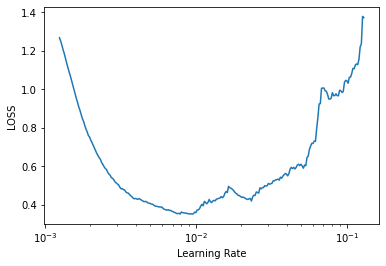

In [28]:
finder.plot()

In [58]:
del model,finder
torch.cuda.empty_cache()

### Training Model

In [35]:
model = models.CustomMobileNet(num_classes=4).cuda()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


In [36]:
opt = torch.optim.Adam(model.parameters(),lr=1e-3)

In [37]:
criterion = nn.CrossEntropyLoss()

In [38]:
#sched = train.get_scheduler(opt,'reduce',patience=3,verbose=True)
sched = train.get_scheduler(opt,'onecycle',max_lr=2e-3,epochs=30,steps_per_epoch = len(dls['train']),div_factor=25,final_div_factor=50)

1 (2,)


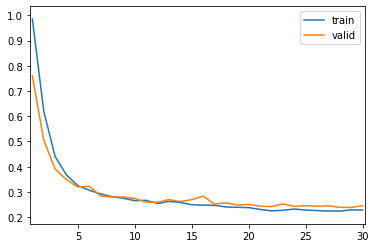

2 (4,)
3 (6,)
4 (8,)
5 (10,)
6 (12,)
7 (14,)
8 (16,)
9 (18,)
10 (20,)
11 (22,)
12 (24,)
13 (26,)
14 (28,)
15 (30,)
16 (32,)
17 (34,)
18 (36,)
19 (38,)
20 (40,)
21 (42,)
22 (44,)
23 (46,)
24 (48,)
25 (50,)
26 (52,)
27 (54,)
28 (56,)
29 (58,)
30 (60,)


In [39]:
results = train.train(model,opt,dls,n_epochs=30,loss_func=criterion,scheduler=sched,sched_loss=True,device='cuda',sched_batchwise=True)

In [40]:
modelpath = '/content/drive/My Drive/EVA/model_optimized.pt'

In [42]:
torch.save(model.state_dict(),modelpath)

### Mis Classification

In [43]:
dls['train'] = DataLoader(train_ds,**dataloader_args)

In [44]:
test_results = test.top5errors(model,dls['valid'])
test_results['probs'] = np.concatenate(test_results['probs'])


In [45]:
train_results = test.top5errors(model,dls['train'])
train_results['probs'] = np.concatenate(train_results['probs'])


In [46]:
print(f"Validation accuracy --> {np.equal(test_results['preds'],test_results['groundtruths']).mean()}")

Validation accuracy --> 0.9120661157024793


In [48]:
print(f"Training Accuracy --> {np.equal(train_results['preds'],train_results['groundtruths']).mean()}")

Training Accuracy --> 0.9386218876664737


In [49]:
cm_train=confusion_matrix(train_results['groundtruths'],train_results['preds'])#,labels=train_ds.dataset.classes)
cm_test=confusion_matrix(test_results['groundtruths'],test_results['preds'])#,labels=train_ds.dataset.classes)

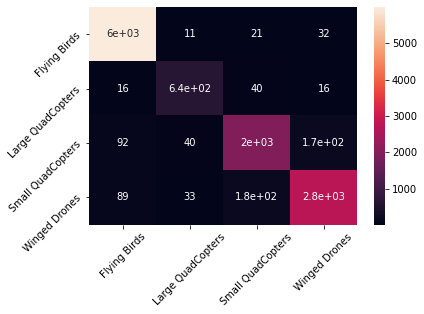

In [51]:
ax=sns.heatmap(cm_train,annot=True)
ax.set_xticklabels(train_ds.classes)
ax.tick_params(axis='x', rotation=45)
ax.set_yticklabels(train_ds.classes)
ax.tick_params(axis='y', rotation=45)


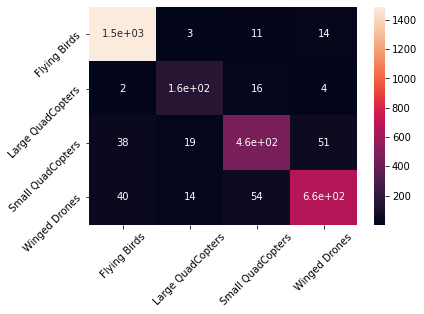

In [52]:
ax=sns.heatmap(cm_test,annot=True)
ax.set_xticklabels(train_ds.classes)
ax.tick_params(axis='x', rotation=45)
ax.set_yticklabels(train_ds.classes)
ax.tick_params(axis='y', rotation=45)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

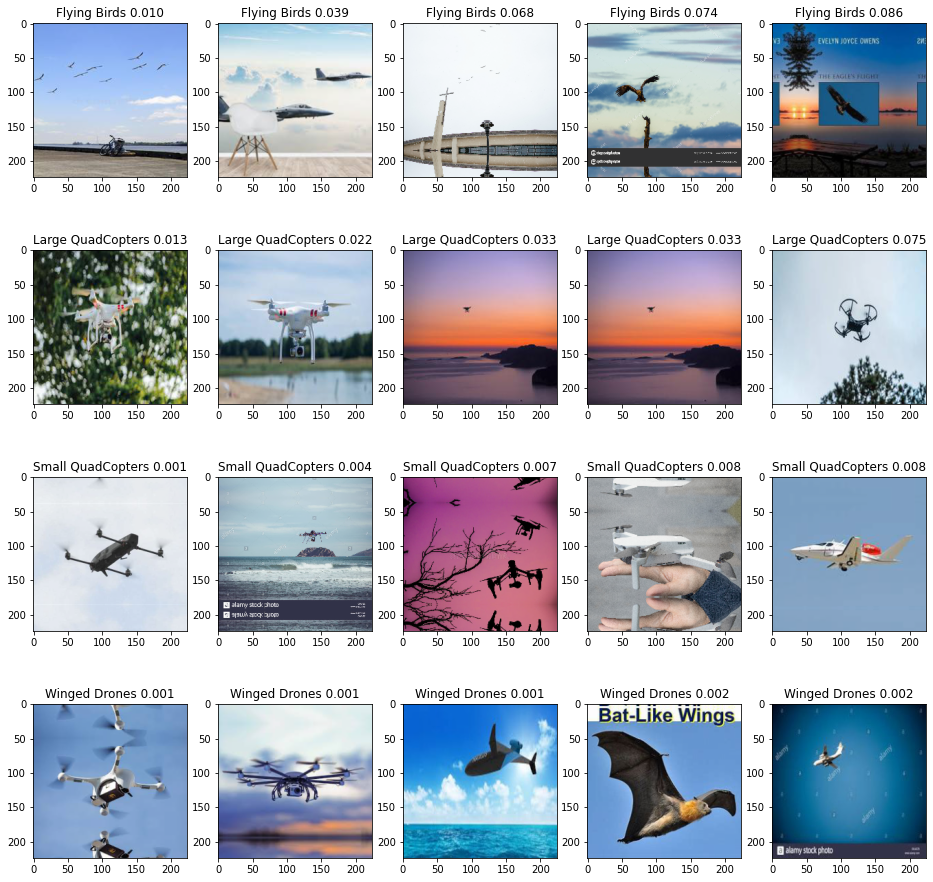

In [54]:
# lowest probability
incorr_birds_train = np.where(np.logical_and(train_results['preds']!=0,train_results['groundtruths']==0))[0]
incorr_large_train = np.where(np.logical_and(train_results['preds']!=1,train_results['groundtruths']==1))[0]
incorr_small_train = np.where(np.logical_and(train_results['preds']!=2,train_results['groundtruths']==2))[0]
incorr_winged_train = np.where(np.logical_and(train_results['preds']!=3,train_results['groundtruths']==3))[0]
all_classes = []
all_idxs =[]
all_probs=[]
for i,(c,v) in enumerate(zip(train_ds.classes,[incorr_birds_train,incorr_large_train,incorr_small_train,incorr_winged_train])):
    all_classes.extend([c]*v.shape[0])
    all_idxs.extend(v)
    all_probs.extend(train_results['probs'][v,i])
incorr_train_df = pd.DataFrame({'objectclass':all_classes,
                                'incorrect_idxs':np.concatenate([incorr_birds_train,incorr_large_train,incorr_small_train,incorr_winged_train]),
                                'probs':all_probs})
fig,axs = plt.subplots(4,5,figsize=(16,16))
for i,c in enumerate(train_ds.classes):
    idxs = incorr_train_df[incorr_train_df.loc[:,'objectclass']==c].sort_values(by='probs')['incorrect_idxs'][:5].values
    temp_probs = incorr_train_df[incorr_train_df.loc[:,'objectclass']==c].sort_values(by='probs')['probs'][:5].values

    for j in range(5):
        axs[i,j].imshow(np.transpose(train_ds[idxs[j]][0].numpy(),(1,2,0))*all_stds+all_means)
        _=axs[i,j].set_title(f'{c} {temp_probs[j]:.3f}')

